In [14]:
import pandas as pd
import numpy as np
import warnings
from glob import glob
import os
import random
import time
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.layers import Conv1D, MaxPooling1D, TimeDistributed, Flatten
from keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils
from keras.optimizers import Adam

%matplotlib inline
# !pip install -q scikit-plot
# !pip install mlxtend

In [15]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [16]:
# file load & merge
directory_path = './final_prpdata_1st/'
file_names = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
file_names = sorted(file_names)
file_names

['df_prp_f_0.csv',
 'df_prp_f_1.csv',
 'df_prp_f_2.csv',
 'df_prp_f_3.csv',
 'df_prp_f_4.csv',
 'df_prp_f_5.csv',
 'df_prp_f_6.csv',
 'df_prp_f_7.csv',
 'df_prp_f_8.csv']

In [17]:
# file load & merge
directory_path = './final_prpdata_1st/'
file_names = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
file_names = sorted(file_names)
dataframes = [pd.read_csv(os.path.join(directory_path, file_name)) for file_name in file_names]
df_prpdata_all = pd.concat(dataframes, ignore_index=True)
# f_mode 컬럼 추가
df_best50 = df_prpdata_all.copy()
conditions = [
    (df_best50['hpt_yn'] == 1) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 1) & (df_best50['lpt_yn'] == 1) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 1) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 1) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 1) & (df_best50['lpc_yn'] == 1),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 1) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 1) & (df_best50['lpt_yn'] == 1) & (df_best50['fan_yn'] == 1) & (df_best50['hpc_yn'] == 1) & (df_best50['lpc_yn'] == 1),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
]
failurMode = ['hpt', 'hpt+lpt', 'fan', 'hpc', 'hpc+lpc', 'lpt', 'all', 'healthy']
df_best50["f_mode"] = np.select(conditions, failurMode, default='None')

## test_size=0.2

In [18]:
featureNamesBest50WANOVA =['climb_hpt_hpc_press_mean',
 'climb_hpt_hpc_press_ratio_mean',
 'climb_hpt_entry_press_ratio_mean',
 'climb_RUL',
 'climb_hpt_hpc_press_min',
 'climb_hpt_hpc_press_ratio_max',
 'cruise_hpt_entry_temp_drop_mean',
 'climb_hpt_entry_press_ratio_max',
 'climb_hpt_entry_temp_drop_mean',
 'cruise_hpt_hpc_press_mean',
 'cruise_hpt_entry_press_ratio_mean',
 'cruise_hpt_hpc_press_ratio_mean',
 'climb_hpt_hpc_temp_mean',
 'climb_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_entry_press_ratio_max',
 'cruise_hpt_hpc_press_min',
 'cruise_hpt_hpc_press_ratio_max',
 'cruise_SmHPC_mean',
 'climb_hpt_entry_press_ratio_min',
 'climb_hpt_hpc_press_ratio_min',
 'climb_hpt_hpc_press_max',
 'climb_fan_exit_press_min',
 'climb_P50_std',
 'climb_hpt_entry_temp_drop_min',
 'climb_SmHPC_mean',
 'climb_SmFan_mean',
 'climb_SmLPC_max',
 'climb_Mach_std',
 'climb_hpc_lpc_temp_max',
 'climb_hpc_lpc_temp_ratio_max',
 'climb_alt_min',
 'cruise_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_hpc_temp_mean',
 'climb_T30_max',
 'climb_hpt_hpc_temp_max',
 'climb_P2_std',
 'cruise_SmLPC_mean',
 'climb_hpt_entry_temp_drop_max',
 'climb_P21_std',
 'climb_P15_std',
 'cruise_hpt_entry_temp_drop_min',
 'climb_W22_std',
 'climb_W25_std',
 'climb_W31_std',
 'climb_W32_std',
 'climb_W50_std',
 'climb_W48_std',
 'climb_P40_std',
 'climb_P30_std',
 'climb_Ps30_std']

featureNamesBest50WANOVA.append('f_mode')

df_best50 = df_best50[featureNamesBest50WANOVA]

# 데이터 준비: df_best50 
X = df_best50.drop('f_mode', axis=1) # f_mode 열을 제외한 나머지 feature = X 

# y = df_best50['f_mode'] # f_mode = Y
y = df_best50['f_mode'].reset_index(drop=True)

# 데이터 전처리_Scaling
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

# 데이터 분할 (stratify=y는 균등한 분포를 위함)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_tr = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_tr = to_categorical(y_train_encoded)

Epoch 1/500
150/150 [==============================] - 3s 6ms/step - loss: 1.9165 - accuracy: 0.3126 - val_loss: 1.7556 - val_accuracy: 0.3528
Epoch 2/500
150/150 [==============================] - 0s 2ms/step - loss: 1.6603 - accuracy: 0.4164 - val_loss: 1.5319 - val_accuracy: 0.4498
Epoch 3/500
150/150 [==============================] - 0s 2ms/step - loss: 1.5416 - accuracy: 0.4542 - val_loss: 1.4596 - val_accuracy: 0.4774
Epoch 4/500
150/150 [==============================] - 0s 2ms/step - loss: 1.5050 - accuracy: 0.4596 - val_loss: 1.4344 - val_accuracy: 0.4883
Epoch 5/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4823 - accuracy: 0.4651 - val_loss: 1.4444 - val_accuracy: 0.4582
Epoch 6/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4712 - accuracy: 0.4628 - val_loss: 1.3923 - val_accuracy: 0.4908
Epoch 7/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4538 - accuracy: 0.4674 - val_loss: 1.3883 - val_accuracy: 0.4766

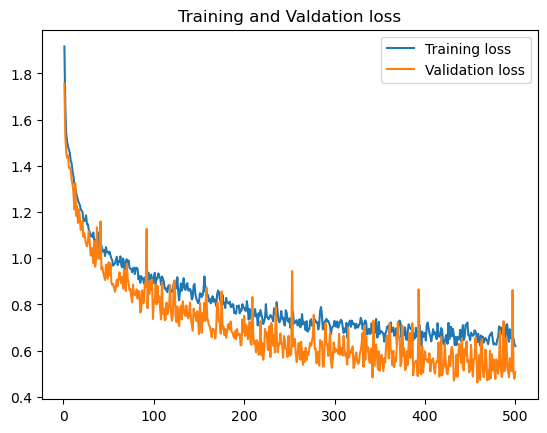

[모델 평가]
47/47 [==============================] - 0s 648us/step
accuracy: 0.8240802675585285
f1: 0.8182962524500443


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

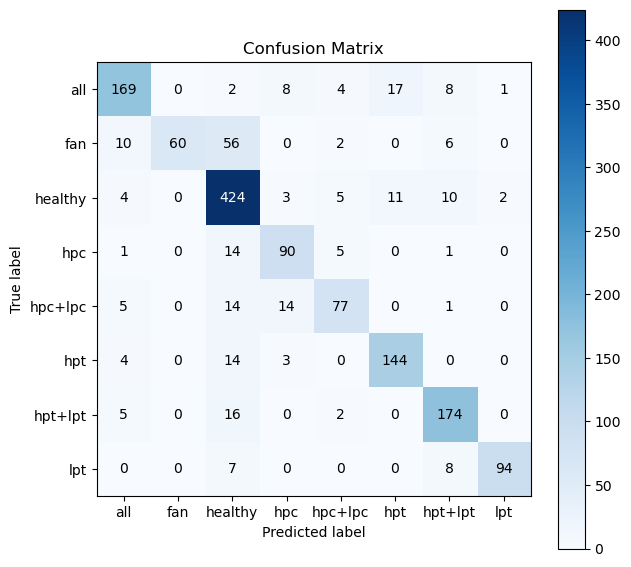

In [19]:
# 모델학습 (shuffle=True)
model = Sequential(name='completeModel')
# model.add(GRU(64, input_shape=(x_tr.shape[1], x_tr.shape[2])))
# model.add(Dense(units=32, activation="tanh"))
# model.add(Dense(units=len(np.unique(y_train)), name='final_dense', activation="softmax"))

model.add(Conv1D(64, kernel_size=5, padding = "same", activation="relu", input_shape = (x_tr.shape[1], x_tr.shape[2])))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2, padding='same'))
# model.add(Conv1D(64, kernel_size=5, padding = "same", activation="relu"))
# model.add(Dropout(0.2))
# model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(TimeDistributed(Flatten()))
model.add(GRU(units = 64, return_sequences=True))   # return_sequences=True : 각 시퀀스별 은닉 상태(hidden state)를 모두 출력
model.add(GRU(units = 64, return_sequences=False))
model.add(Dense(units=32, activation="tanh"))
model.add(Dense(units=len(np.unique(y_train)), name='final_dense', activation="softmax"))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]) 
history = model.fit(x_tr, y_tr, epochs=500, validation_split=0.2, shuffle=True)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show() 

# 통합모델 평가
print('[모델 평가]')
x_ts = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]) 
y_ts = to_categorical(y_test)

predictions = model.predict(x_ts)
y_pred_classes = np.argmax(predictions, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test, y_pred_classes)        

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")

skplt.metrics.plot_confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_classes), figsize=(7,7))

## test_size=0.4

In [8]:
featureNamesBest50WANOVA =['climb_hpt_hpc_press_mean',
 'climb_hpt_hpc_press_ratio_mean',
 'climb_hpt_entry_press_ratio_mean',
 'climb_RUL',
 'climb_hpt_hpc_press_min',
 'climb_hpt_hpc_press_ratio_max',
 'cruise_hpt_entry_temp_drop_mean',
 'climb_hpt_entry_press_ratio_max',
 'climb_hpt_entry_temp_drop_mean',
 'cruise_hpt_hpc_press_mean',
 'cruise_hpt_entry_press_ratio_mean',
 'cruise_hpt_hpc_press_ratio_mean',
 'climb_hpt_hpc_temp_mean',
 'climb_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_entry_press_ratio_max',
 'cruise_hpt_hpc_press_min',
 'cruise_hpt_hpc_press_ratio_max',
 'cruise_SmHPC_mean',
 'climb_hpt_entry_press_ratio_min',
 'climb_hpt_hpc_press_ratio_min',
 'climb_hpt_hpc_press_max',
 'climb_fan_exit_press_min',
 'climb_P50_std',
 'climb_hpt_entry_temp_drop_min',
 'climb_SmHPC_mean',
 'climb_SmFan_mean',
 'climb_SmLPC_max',
 'climb_Mach_std',
 'climb_hpc_lpc_temp_max',
 'climb_hpc_lpc_temp_ratio_max',
 'climb_alt_min',
 'cruise_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_hpc_temp_mean',
 'climb_T30_max',
 'climb_hpt_hpc_temp_max',
 'climb_P2_std',
 'cruise_SmLPC_mean',
 'climb_hpt_entry_temp_drop_max',
 'climb_P21_std',
 'climb_P15_std',
 'cruise_hpt_entry_temp_drop_min',
 'climb_W22_std',
 'climb_W25_std',
 'climb_W31_std',
 'climb_W32_std',
 'climb_W50_std',
 'climb_W48_std',
 'climb_P40_std',
 'climb_P30_std',
 'climb_Ps30_std']

featureNamesBest50WANOVA.append('f_mode')

df_best50 = df_best50[featureNamesBest50WANOVA]

# 데이터 준비: df_best50 
X = df_best50.drop('f_mode', axis=1) # f_mode 열을 제외한 나머지 feature = X 

# y = df_best50['f_mode'] # f_mode = Y
y = df_best50['f_mode'].reset_index(drop=True)

# 데이터 전처리_Scaling
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

# 데이터 분할 (stratify=y는 균등한 분포를 위함)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.4,
                                                    random_state=42,
                                                    stratify=y)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_tr = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_tr = to_categorical(y_train_encoded)

Epoch 1/500
113/113 [==============================] - 2s 5ms/step - loss: 1.9312 - accuracy: 0.3087 - val_loss: 1.8149 - val_accuracy: 0.3935
Epoch 2/500
113/113 [==============================] - 0s 2ms/step - loss: 1.7252 - accuracy: 0.3846 - val_loss: 1.5946 - val_accuracy: 0.4025
Epoch 3/500
113/113 [==============================] - 0s 2ms/step - loss: 1.5824 - accuracy: 0.4317 - val_loss: 1.5500 - val_accuracy: 0.4359
Epoch 4/500
113/113 [==============================] - 0s 2ms/step - loss: 1.5334 - accuracy: 0.4492 - val_loss: 1.4674 - val_accuracy: 0.4716
Epoch 5/500
113/113 [==============================] - 0s 2ms/step - loss: 1.5104 - accuracy: 0.4504 - val_loss: 1.5413 - val_accuracy: 0.4548
Epoch 6/500
113/113 [==============================] - 0s 2ms/step - loss: 1.4844 - accuracy: 0.4607 - val_loss: 1.4539 - val_accuracy: 0.4693
Epoch 7/500
113/113 [==============================] - 0s 2ms/step - loss: 1.4598 - accuracy: 0.4663 - val_loss: 1.4826 - val_accuracy: 0.4448

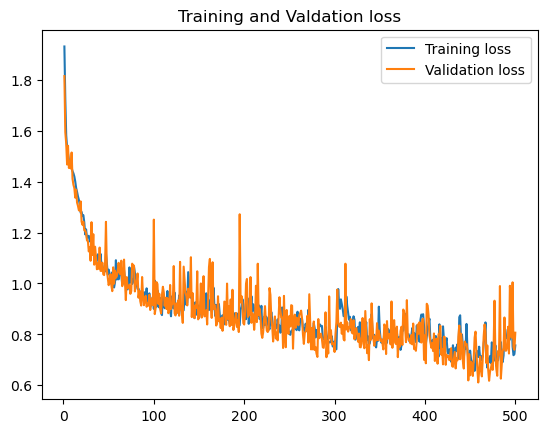

[모델 평가]
94/94 [==============================] - 1s 633us/step
accuracy: 0.7361204013377927
f1: 0.7257428207317801


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

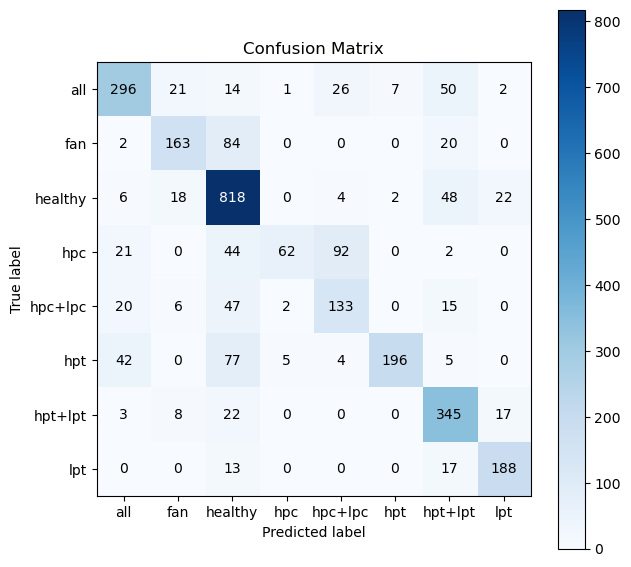

In [9]:
# 모델학습 (shuffle=True)
model = Sequential(name='completeModel')
# model.add(GRU(64, input_shape=(x_tr.shape[1], x_tr.shape[2])))
# model.add(Dense(units=32, activation="tanh"))
# model.add(Dense(units=len(np.unique(y_train)), name='final_dense', activation="softmax"))

model.add(Conv1D(64, kernel_size=5, padding = "same", activation="relu", input_shape = (x_tr.shape[1], x_tr.shape[2])))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2, padding='same'))
# model.add(Conv1D(64, kernel_size=5, padding = "same", activation="relu"))
# model.add(Dropout(0.2))
# model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(TimeDistributed(Flatten()))
model.add(GRU(units = 64, return_sequences=True))   # return_sequences=True : 각 시퀀스별 은닉 상태(hidden state)를 모두 출력
model.add(GRU(units = 64, return_sequences=False))
model.add(Dense(units=32, activation="tanh"))
model.add(Dense(units=len(np.unique(y_train)), name='final_dense', activation="softmax"))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]) 
history = model.fit(x_tr, y_tr, epochs=500, validation_split=0.2, shuffle=True)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show() 

# 통합모델 평가
print('[모델 평가]')
x_ts = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]) 
y_ts = to_categorical(y_test)

predictions = model.predict(x_ts)
y_pred_classes = np.argmax(predictions, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test, y_pred_classes)        

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")

skplt.metrics.plot_confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_classes), figsize=(7,7))

In [288]:
display(model.summary())

Model: "completeModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 1, 64)             16064     
                                                                 
 dropout_36 (Dropout)        (None, 1, 64)             0         
                                                                 
 max_pooling1d_44 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_45 (Conv1D)          (None, 1, 64)             20544     
                                                                 
 dropout_37 (Dropout)        (None, 1, 64)             0         
                                                                 
 max_pooling1d_45 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                               

None

Epoch 1/1000
106/106 [==============================] - 2s 4ms/step - loss: 2.1107 - accuracy: 0.1870 - val_loss: 2.7169 - val_accuracy: 0.0000e+00
Epoch 2/1000
106/106 [==============================] - 0s 2ms/step - loss: 2.1573 - accuracy: 0.1976 - val_loss: 2.9993 - val_accuracy: 0.0296
Epoch 3/1000
106/106 [==============================] - 0s 2ms/step - loss: 2.0353 - accuracy: 0.2681 - val_loss: 3.0244 - val_accuracy: 0.2192
Epoch 4/1000
106/106 [==============================] - 0s 2ms/step - loss: 1.9430 - accuracy: 0.2862 - val_loss: 2.9453 - val_accuracy: 0.2393
Epoch 5/1000
106/106 [==============================] - 0s 2ms/step - loss: 1.8678 - accuracy: 0.2972 - val_loss: 2.8887 - val_accuracy: 0.2097
Epoch 6/1000
106/106 [==============================] - 0s 2ms/step - loss: 1.7954 - accuracy: 0.3369 - val_loss: 2.9646 - val_accuracy: 0.2488
Epoch 7/1000
106/106 [==============================] - 0s 2ms/step - loss: 1.7274 - accuracy: 0.3520 - val_loss: 3.0454 - val_accur

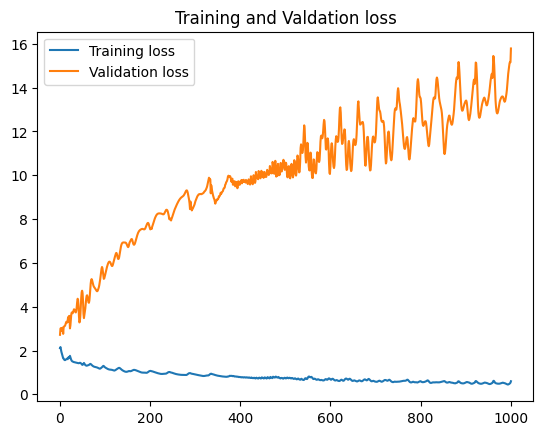

[모델 평가]
84/84 [==============================] - 0s 874us/step
accuracy: 0.6319315221436547
f1: 0.6083466212330332


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

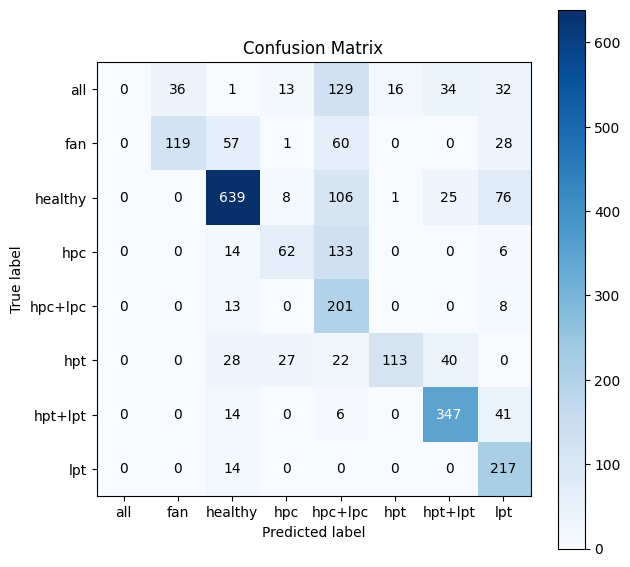

In [249]:
# 모델학습 (shuffle=False)
model = Sequential(name='completeModel')
model.add(GRU(64, input_shape=(x_tr.shape[1], x_tr.shape[2])))
model.add(Dense(units=32, activation="tanh"))
model.add(Dense(units=len(np.unique(y_train)), name='final_dense', activation="softmax"))
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]) 
history = model.fit(x_tr, y_tr, epochs=1000, validation_split=0.2, shuffle=False)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show() 

# 통합모델 평가
print('[모델 평가]')
x_ts = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]) 
y_ts = to_categorical(y_test)

predictions = model.predict(x_ts)
y_pred_classes = np.argmax(predictions, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test, y_pred_classes)        

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")

skplt.metrics.plot_confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_classes), figsize=(7,7))

In [234]:
# unit 별 누적 모델
X_full_train = train_set.drop('f_mode', axis=1)[add_featureNamesBest50WANOVA].reset_index(drop=True)
y_full_train = train_set['f_mode'].reset_index(drop=True)
X_full_test = test_set.drop('f_mode', axis=1)[add_featureNamesBest50WANOVA].reset_index(drop=True)
y_full_test = test_set['f_mode'].reset_index(drop=True)

y_train = encoder.transform(y_full_train)
y_test = encoder.transform(y_full_test)
# y_train = pd.get_dummies(y_full_train).astype(int)
# y_test = pd.get_dummies(y_full_test).astype(int)

X_full_grouped = X_full_train.groupby(['fileNo', 'unit'])
y_train_dummy = to_categorical(y_train)

model = Sequential(name='accumulate_model')
model.add(GRU(64, input_shape=(1, 50)))
model.add(Dense(units=32, activation="tanh"))        # activation="relu"
model.add(Dense(units=y_train_dummy.shape[1], name='final_dense', activation="softmax"))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]) 

gi = 0
previous_weights = None
f1_w = None
f2_w = None
f3_w = None
f4_w = None
f5_w = None
f6_w = None
f7_w = None
f8_w = None

for group_idx, group in X_full_grouped :
    fileNo = group_idx[0]
    unitNo = group_idx[1]
    print(f'[{gi+1} / {len(X_full_grouped)}] fileNo.{int(fileNo)} unitNo :{unitNo}')

    X_unit = group.drop(columns=['fileNo', 'unit'])
    y_unit = y_train_dummy[X_unit.index]

    X_unit = scaler.transform(X_unit[featureNamesBest50WANOVA])
    X_unit = X_unit.reshape(X_unit.shape[0], 1, X_unit.shape[1])    # DNN 모델 input 처리를 위해 3차원으로 변경
    print(X_unit.shape)

    # if previous_weights is not None:
    #     model.set_weights(previous_weights)  # 이전 유닛의 학습 상태를 초기 상태로 설정

    # if fileNo == 0 and f1_w is not None :
    #     model.set_weights(f1_w)
    # elif fileNo == 1 and f2_w is not None :
    #     model.set_weights(f2_w)
    # elif fileNo == 2 and f3_w is not None :
    #     model.set_weights(f3_w)
    # elif fileNo == 3 and f4_w is not None :
    #     model.set_weights(f4_w)
    # elif fileNo == 4 and f5_w is not None :
    #     model.set_weights(f5_w)
    # elif fileNo == 5 and f6_w is not None :
    #     model.set_weights(f6_w)
    # elif fileNo == 6 and f7_w is not None :
    #     model.set_weights(f7_w)
    # elif fileNo == 7 and f8_w is not None :
    #     model.set_weights(f8_w)

    model.fit(X_unit, y_unit, epochs=50, verbose=False, shuffle=False)

    # previous_weights = model.get_weights()  # 현재 유닛의 학습 상태 저장
    
    # if fileNo == 0 :
    #     f1_w = model.get_weights()
    # elif fileNo == 1 :
    #     f2_w = model.get_weights()
    # elif fileNo == 2 :
    #     f3_w = model.get_weights()
    # elif fileNo == 3 :
    #     f4_w = model.get_weights()
    # elif fileNo == 4 :
    #     f5_w = model.get_weights()
    # elif fileNo == 5 :
    #     f6_w = model.get_weights()
    # elif fileNo == 6 :
    #     f7_w = model.get_weights()
    # elif fileNo == 7 :
    #     f8_w = model.get_weights()

    gi = gi+1 

[1 / 54] fileNo.0 unitNo :1.0
(100, 1, 50)
[2 / 54] fileNo.0 unitNo :2.0
(75, 1, 50)
[3 / 54] fileNo.0 unitNo :3.0
(100, 1, 50)
[4 / 54] fileNo.0 unitNo :4.0
(95, 1, 50)
[5 / 54] fileNo.0 unitNo :5.0
(89, 1, 50)
[6 / 54] fileNo.0 unitNo :6.0
(94, 1, 50)
[7 / 54] fileNo.1 unitNo :2.0
(75, 1, 50)
[8 / 54] fileNo.1 unitNo :5.0
(89, 1, 50)
[9 / 54] fileNo.1 unitNo :10.0
(82, 1, 50)
[10 / 54] fileNo.1 unitNo :16.0
(63, 1, 50)
[11 / 54] fileNo.1 unitNo :18.0
(71, 1, 50)
[12 / 54] fileNo.1 unitNo :20.0
(66, 1, 50)
[13 / 54] fileNo.2 unitNo :1.0
(72, 1, 50)
[14 / 54] fileNo.2 unitNo :2.0
(73, 1, 50)
[15 / 54] fileNo.2 unitNo :3.0
(67, 1, 50)
[16 / 54] fileNo.2 unitNo :4.0
(60, 1, 50)
[17 / 54] fileNo.2 unitNo :5.0
(93, 1, 50)
[18 / 54] fileNo.2 unitNo :6.0
(63, 1, 50)
[19 / 54] fileNo.2 unitNo :7.0
(80, 1, 50)
[20 / 54] fileNo.2 unitNo :8.0
(71, 1, 50)
[21 / 54] fileNo.2 unitNo :9.0
(84, 1, 50)
[22 / 54] fileNo.3 unitNo :1.0
(87, 1, 50)
[23 / 54] fileNo.3 unitNo :2.0
(73, 1, 50)
[24 / 54] file

84/84 [==============================] - 0s 901us/step
accuracy: 0.24823222925195385
f1: 0.2212085536288503


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

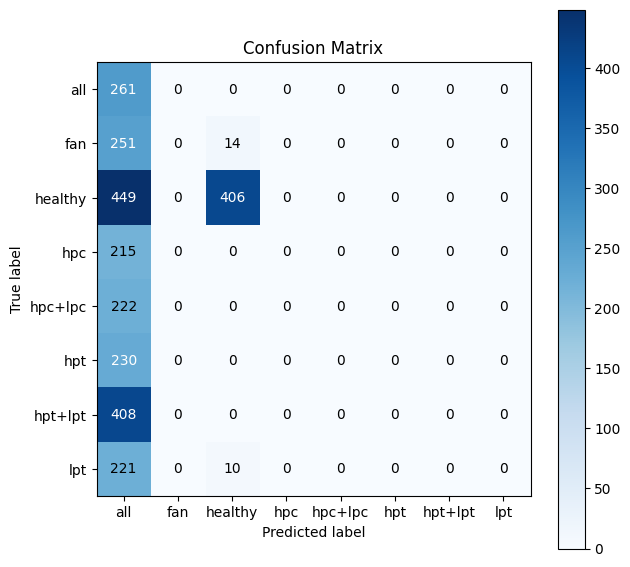

In [235]:
# unit 별 누적 모델 평가
X_test_scaled = scaler.transform(X_full_test[featureNamesBest50WANOVA])    
x_ts = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1]) 
y_ts = to_categorical(y_test)

predictions = model.predict(x_ts)
y_pred_classes = np.argmax(predictions, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test, y_pred_classes)        

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")

skplt.metrics.plot_confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_classes), figsize=(7,7))

In [ ]:
def createModel(shape, label_size, modelName='complete') :
    print(shape, label_size, modelName)

    model = Sequential(name=modelName)
    # model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape[1], shape[2])))
    # model.add(LSTM(64, recurrent_dropout=0.2, return_sequences=True, input_shape=(shape[1], shape[2])))
    # model.add(LSTM(64, input_shape=(shape[1], shape[2]), return_sequences=True))
    # model.add(Dropout(0.2))  # 드롭아웃 레이어 추가
    # model.add(GRU(units=32))  # GRU 레이어 추가

    # model.add(LSTM(64, input_shape=(shape[1], shape[2])))
    # model.add(Dense(units=32, activation="relu"))
    # model.add(Dense(units=label_size, name='final_dense', activation="softmax"))

    model.add(GRU(64, input_shape=(shape[1], shape[2])))
    model.add(Dense(units=32, activation="tanh"))
    model.add(Dense(units=label_size, name='final_dense', activation="softmax"))

    # model.add(LSTM(128, input_shape=(shape[1], shape[2])))
    # model.add(LSTM(64, activation = "tanh"))
    # model.add(GRU(units=32, activation = "tanh"))
    # model.add(Dense(units=32, activation="tanh"))
    # model.add(Dense(units=64, activation="relu"))
    # model.add(Dense(units=label_size, name='final_dense', activation="softmax"))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]) 

    return model

def processData(X, y, window=1, shift=1):
    partitions = int(np.floor((len(X) - window) / shift)) + 1
    features = X.shape[1]
    print(partitions, features)

    X_data = np.repeat(np.nan, repeats = partitions * window * features).reshape(partitions, window, features)
    y_data = np.repeat(np.nan, repeats = partitions)
    for i in range(partitions):
        X_data[i, :, :] = X[(0 + shift * i): (0 + shift * i + window), :]
        y_data[i] = y[(shift * i + (window - 1))]

    y_data = to_categorical(y_data)

    return X_data, y_data